# Training data preparation

In this notebook, we explore the PharmGKB data and prepare it for training.

In [34]:
# Imports
import pandas as pd
import os
from tqdm import tqdm
import random
from rdkit import Chem
from rdkit import RDLogger
import numpy as np
import datetime
import string
import json
import warnings
RDLogger.DisableLog('rdApp.*')

import sys
sys.path.append("../src")

# Read main processed PharmGKB table
df = pd.read_csv("../data/pharmgkb_processed/final_tables/pgkb_merged.csv", low_memory=False)


def table_statistics(df):
    pairs = set([tuple(x) for x in df[["cid", "gid"]].values])
    triplets = set([tuple(x) for x in df[["cid", "vid", "gid"]].values])
    print("Compounds: ", len(set(df["cid"])))
    print("Genes:     ", len(set(df["gid"])))
    print("Variants:  ", len(set(df["vid"])))
    print("Pairs:     ", len(pairs))
    print("Triplets:  ", len(triplets))

table_statistics(df)

Compounds:  1190
Genes:      1949
Variants:   6986
Pairs:      9790
Triplets:   49958


In [35]:
# Focus genes are ADME genes provided by H3D
focus_genes = pd.read_csv("../data/of_interest/adme_gene_list.tsv", sep="\t")

# Focus compounds are antimalarial and antituberculosis drugs provided by H3D
focus_compounds = pd.read_csv("../data/of_interest/curated_drugs_for_gradient.tsv", sep="\t")
inchikeys = []
for smi in focus_compounds["SMILES"].tolist():
    mol = Chem.MolFromSmiles(smi)
    inchi = Chem.rdinchi.MolToInchi(mol)[0]
    inchikey = Chem.rdinchi.InchiToInchiKey(inchi)
    inchikeys += [inchikey]
focus_compounds["inchikey"] = inchikeys

In [22]:
df = df[df["gid"].isin(focus_genes["PharmGKB ID"].tolist())]
table_statistics(df)

Compounds:  774
Genes:      171
Variants:   2527
Pairs:      3140
Triplets:   35122


In [36]:
# Map compounds to InChIKeys
cid2smi = {}
for r in df[["cid", "smiles"]].values:
    if str(r[1]) != "nan":
        cid2smi[r[0]] = r[1]
cid2key = {}
for k,v in tqdm(cid2smi.items()):
    mol = Chem.MolFromSmiles(v)
    inchi = Chem.rdinchi.MolToInchi(mol)[0]
    inchikey = Chem.rdinchi.InchiToInchiKey(inchi)
    cid2key[k] = inchikey

# Map genes to UniProt ACs
hp = pd.read_csv("../data/other/human_proteome_with_genenames.tab", sep="\t")
cols = list(hp.columns)
hp = hp[(hp[cols[0]].notnull()) & (hp[cols[2]].notnull())]
g2p = {}
up = pd.read_csv(
    os.path.join(
        "..", "data", "other", "human_proteome_with_genenames.tab"
    ),
    sep="\t",
)
for v in up[
    ["Entry", "Gene names", "Gene names  (primary )", "Gene names  (synonym )"]
].values:
    p = v[0]
    g = []
    for x in v[1:]:
        x = str(x)
        if x == "nan":
            continue
        for y in x.split(" "):
            g += [y]
    for x in g:
        g2p[x] = p

gid2key = {}
for r in df[["gid", "gene"]].values:
    if str(r[0]) == "nan" or str(r[1]) == "nan":
        continue
    if r[1] not in g2p:
        continue
    gid2key[r[0]] = g2p[r[1]]

100%|██████████| 904/904 [00:00<00:00, 3373.53it/s]


In [37]:
# Filter to only consider PK relationships
#df = df[df["phenotype"].isin(["Metabolism/PK"])]#, "Toxicity", "Dosage"])]
df = df[df["significance"] != -1]
df = df[df["evidence"] != "4"]

# Build a unique set of triplets
triplets = set()
for r in df[["cid", "chemical", "gid", "gene", "vid", "variant"]].values:
    r = tuple(r)
    if r[0] not in cid2key:
        ckey = None
    else:
        ckey = cid2key[r[0]]
    if r[2] not in gid2key:
        gkey = None
    else:
        gkey = gid2key[r[2]]
    if gkey is None or ckey is None:
        continue
    triplets.update([(ckey, r[0], r[1], gkey, r[3], r[2], r[5], r[4])])
triplets = list(triplets)
triplets = list(set(triplets))

dt = pd.DataFrame(triplets, columns=["inchikey", "cid", "chemical", "uniprot_ac", "gene", "gid", "variant", "vid"])
table_statistics(dt)

Compounds:  859
Genes:      1328
Variants:   3960
Pairs:      5686
Triplets:   32668


In [38]:
from samplers import PositiveNegativeSampler

ds = PositiveNegativeSampler(dt, 10).sample()

In [39]:
from splitters import RandomPairSplitter

ds_tr, ds_te = RandomPairSplitter().split(ds)

In [40]:
from compound_structures import CompoundStructureEmbedding
from protein_sequences import ProteinSequenceEmbedding
from bioteque import BiotequeGeneEmbedding

bge = BiotequeGeneEmbedding()
pse = ProteinSequenceEmbedding()
cse = CompoundStructureEmbedding()

cemb_list = []
for x in cse.available():
    cemb_list += [(x, CompoundStructureEmbedding(x).get())]

pemb_list = []
for x in pse.available():
    pemb_list += [(x, ProteinSequenceEmbedding(x).get())]

for x in bge.available().values:
    pemb_list += [(x, BiotequeGeneEmbedding(x[0], x[1]).get())]

In [41]:
from bimodal_model import EnsembleBimodalStackedModel

model = EnsembleBimodalStackedModel(cemb_list[:1], pemb_list[:1])
model.fit(ds_tr)
model.evaluate(ds_te)
model_folder = model.model_folder
model = load_ensemble_bimodal_stacked_model(model_folder)
df = model.predict(ds_te)

Fitting: ersilia---esm1b
ersilia---esm1b 10904 0.6768487510049374
{
    "ersilia---esm1b": {
        "auroc": 0.6768487510049374,
        "n_eval": 10904
    },
    "average": {
        "auroc": 0.6768487510049374,
        "n_eval": 10904
    },
    "weighted_average": {
        "auroc": 0.6768487510049374,
        "n_eval": 10904
    }
}


In [33]:
df

,inchikey,cid,chemical,uniprot_ac,gene,gid,y,y_hat
0,OEKWJQXRCDYSHL-FNOIDJSQSA-N,PA165374673,ticagrelor,P11509,CYP2A6,PA121,0,0.160000
1,NCDNCNXCDXHOMX-XGKFQTDJSA-N,PA451260,ritonavir,P05177,CYP1A2,PA27093,0,0.050000
2,WINHZLLDWRZWRT-ATVHPVEESA-N,PA162372840,sunitinib,P20813,CYP2B6,PA123,0,0.060000
3,BCEHBSKCWLPMDN-MGPLVRAMSA-N,PA10233,voriconazole,P11712,CYP2C9,PA126,1,0.336417
4,YASAKCUCGLMORW-UHFFFAOYSA-N,PA451283,rosiglitazone,O75469,NR1I2,PA378,0,0.040000
...,...,...,...,...,...,...,...,...
1651,OEKWJQXRCDYSHL-FNOIDJSQSA-N,PA165374673,ticagrelor,Q6N069,NAT2,PA18,0,0.130000
1652,RCINICONZNJXQF-MZXODVADSA-N,PA450761,paclitaxel,Q9HAW9,UGT1A8,PA37183,0,0.010000
1653,PMATZTZNYRCHOR-KMSBSJHKSA-N,PA449167,cyclosporine,P33527,ABCC1,PA244,0,NaN
1654,KTUFNOKKBVMGRW-UHFFFAOYSA-N,PA10804,imatinib,P19224,UGT1A6,PA37181,0,0.040000


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(df[df["y_hat"].notnull()]["y"], df[df["y_hat"].notnull()]["y_hat"])

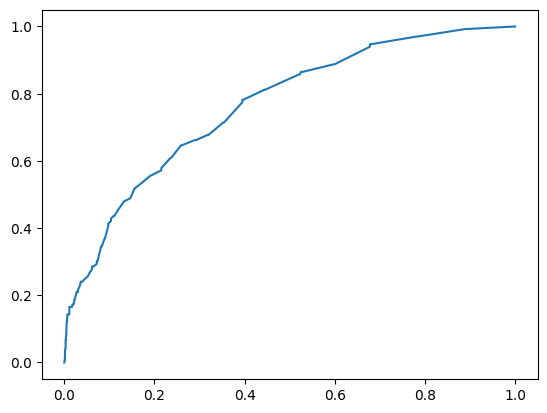

In [32]:
plt.plot(fpr, tpr)